Calculating f_H values...
Integral of original f_H: 2.301524e-01
Integral of normalized f_H: 1.000000
Execution time: 0.41 seconds

Summary of results:
Original integral value: 2.301524e-01
Normalized integral value: 1.000000
Final CDF value: 1.000210
Execution time: 0.41 seconds


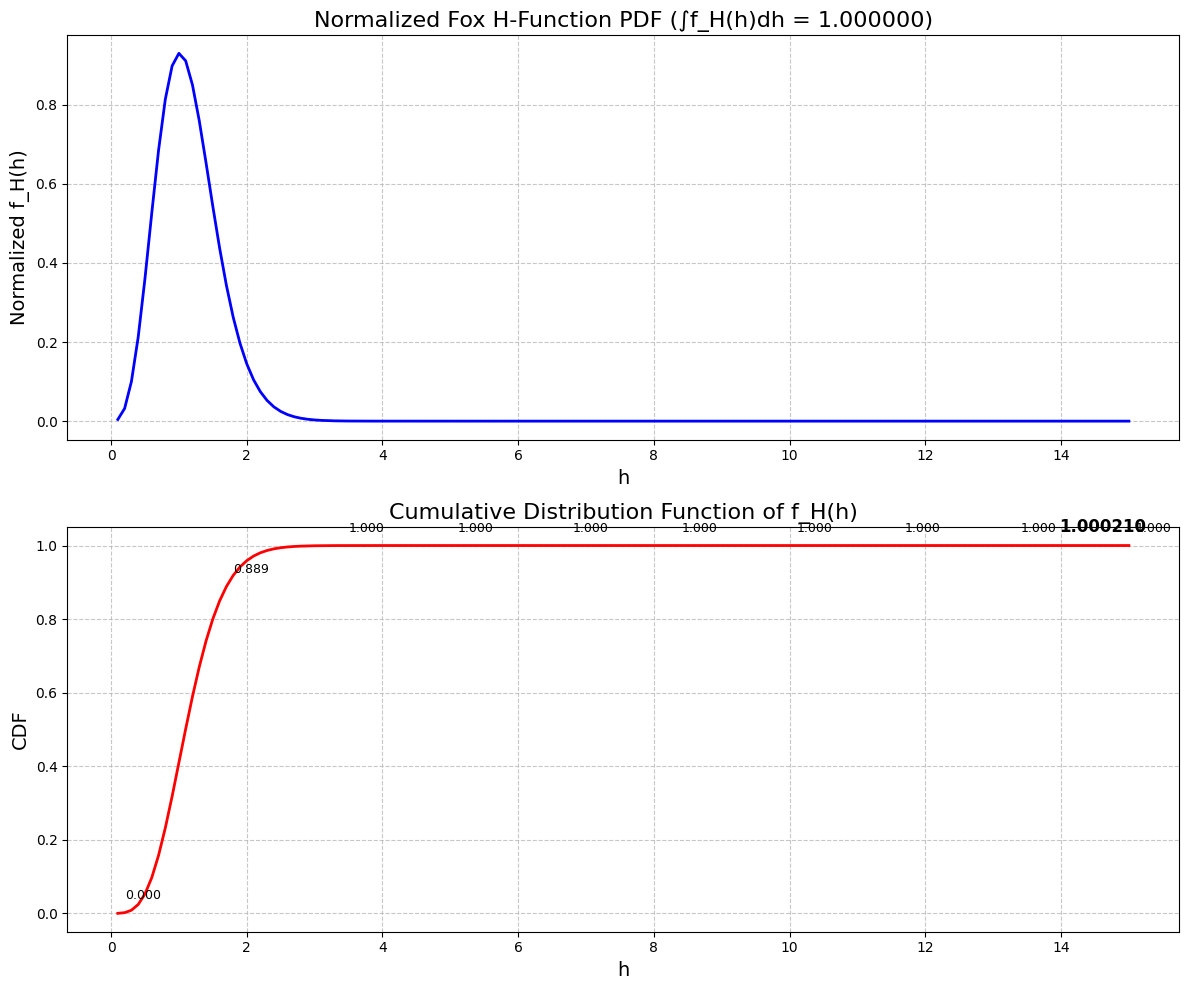

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp
import scipy.special as sp
from functools import lru_cache
import time

# Set precision for mpmath but not too high to balance accuracy and speed
mp.dps = 25

@lru_cache(maxsize=1024)
def R_v_mu(v, mu, x):
    """
    Calculate the R function used in the coefficient a_j computation.
    LRU cache added for performance improvement.
    
    Parameters:
    -----------
    v : float
        v parameter
    mu : float
        mu parameter
    x : float
        x parameter
        
    Returns:
    --------
    float
        R function value
    """
    try:
        # Check if mu is a positive integer
        if (mu > 0) and (mu == int(mu)):
            mu_int = int(mu)  # Convert to integer
            
            # Calculate Pochhammer symbols
            term1 = mp.rf((v - mu)/2, mu_int)  # Rising factorial (Pochhammer symbol)
            term2 = mp.rf((v - mu + 1)/2, mu_int)
            
            # Calculate numerator factor
            num_factor = (term1 * term2 / mp.factorial(mu_int)) * (x**mu_int)
            
            # Calculate hypergeometric function
            hyper = mp.hyper([(v+mu)/2, (v+mu+1)/2], [1+mu], x)
            R_value = num_factor * hyper
        else:
            # Calculate hypergeometric function for non-integer mu
            hyper = mp.hyper([(v - mu)/2, (v - mu + 1)/2], [1 - mu], x)
            R_value = hyper / mp.gamma(1 - mu)
        
        return float(R_value)
    except (OverflowError, ValueError, ZeroDivisionError):
        # Return 0 if there's a numerical issue
        return 0.0

# Cache a_j calculations for significant performance improvement
@lru_cache(maxsize=128)
def compute_a_j(j, m, K, Delta=1):
    """
    Compute the coefficient a_j used in the Fox H-function expansion.
    LRU cache added for performance improvement.
    
    Parameters:
    -----------
    j : int
        Index of coefficient
    m : float
        The m parameter from the system
    K : float
        The K parameter from the system
    Delta : float
        Delta parameter, default is 1
        
    Returns:
    --------
    float
        Coefficient a_j
    """
    try:
        # Calculate argument for R function
        arg2 = ((K * Delta) / (m + K))**2
        
        total_sum = 0
        
        # Loop over k from 0 to j
        for k_ in range(j + 1):
            # Calculate binomial coefficient for j choose k
            cjk = mp.binomial(j, k_)
            inner_sum = 0
            
            # Loop over l from 0 to k
            for l_ in range(k_ + 1):
                gam_fac = j + m + 2*l_ - k_
                ckl = mp.binomial(k_, l_)
                gamma_val = mp.gamma(gam_fac)
                first_factor = ckl * gamma_val
                sec_factor = ((m + K)**(-gam_fac)) * (K**(2*l_ - k_)) * ((Delta/2)**(2*l_))
                power_sign = (-1)**(2*l_ - k_)
                
                v_val = j + m
                mu_val = k_ - 2*l_
                
                # Calculate R function
                R_val = R_v_mu(v_val, mu_val, arg2)
                
                third_factor = power_sign * R_val
                inner_term = first_factor * sec_factor * third_factor
                inner_sum = inner_sum + inner_term
            
            middle_mul = inner_sum * cjk
            total_sum = total_sum + middle_mul
        
        return float(total_sum)
    except (OverflowError, ValueError, ZeroDivisionError):
        # Return 0 if there's a numerical issue
        return 0.0

# Pre-compute factorial values for reuse
@lru_cache(maxsize=128)
def cached_factorial_squared(j):
    """Cache factorial squared calculations for performance."""
    return float(mp.factorial(j)**2)

def calculate_f_H(h, rho, m, K, A0, hl, n_terms=20, j_offset=2):
    """
    Calculate the f_H(h) function with optimized performance.
    
    Parameters:
    -----------
    h : float or array-like
        Input variable h
    rho : float
        Rho parameter
    m : float
        m parameter
    K : float
        K parameter (also used to calculate sigma^2 = 1/(2(K+1)))
    A0 : float
        A0 parameter
    hl : float
        hl parameter
    n_terms : int, optional
        Number of terms to use in the summation (default 20)
    j_offset : int, optional
        Offset for j to avoid numerical issues (default 2)
        
    Returns:
    --------
    float or array-like
        Result of f_H(h)
    """
    # Calculate sigma from K using the formula σ^2 = 1/(2(K+1))
    sigma_squared = 1/(2*(K+1))
    sigma = np.sqrt(sigma_squared)
    
    # Ensure h is a numpy array
    h_array = np.atleast_1d(h)
    scalar_input = h_array.size == 1
    
    # Precompute constants to avoid redundant calculations
    numerator = (rho**2) * (m**m)
    denominator_term1 = (2 * sigma**2 * A0**2 * hl**2)**(rho**2 / 2)
    denominator_term2 = float(mp.gamma(m))
    denominator = denominator_term1 * denominator_term2
    
    # Determine safe starting j value to avoid gamma function poles
    j_start = max(j_offset, int(np.ceil(rho**2/2 - 0.5)))
    
    # Initialize result array
    result = np.zeros_like(h_array, dtype=float)
    
    # Vectorized calculation for h^(rho^2 - 1)
    h_power = h_array**(rho**2 - 1)
    
    # Pre-compute a_j values (they don't depend on h)
    a_j_values = np.zeros(n_terms)
    factorial_values = np.zeros(n_terms)
    
    for j_idx, j in enumerate(range(j_start, j_start + n_terms)):
        try:
            a_j_values[j_idx] = compute_a_j(j, m, K)
            factorial_values[j_idx] = cached_factorial_squared(j)
        except Exception:
            a_j_values[j_idx] = 0.0
            factorial_values[j_idx] = 1.0  # Avoid division by zero
    
    # Calculate gamma arguments that are common for all h values
    gamma_arg1_values = np.array([j - rho**2/2 + 1 for j in range(j_start, j_start + n_terms)])
    
    # Calculate for each h value - this is the most time-consuming part
    for i, h_val in enumerate(h_array):
        summation = 0.0
        
        # Calculate h-dependent gamma argument (reused across j values)
        gamma_arg2 = h_val**2 / (2 * sigma**2 * A0**2 * hl**2)
        
        for j_idx, j in enumerate(range(j_start, j_start + n_terms)):
            try:
                # Skip if a_j is zero or if we're at a gamma function pole
                if a_j_values[j_idx] == 0 or gamma_arg1_values[j_idx] <= 0:
                    continue
                
                # Use scipy's incomplete gamma function (vectorized and fast)
                gamma_part = float(sp.gammaincc(gamma_arg1_values[j_idx], gamma_arg2) * 
                                   sp.gamma(gamma_arg1_values[j_idx]))
                
                # Calculate term using pre-computed values
                term = (a_j_values[j_idx] * (K**j)) / factorial_values[j_idx] * gamma_part
                summation += term
            except Exception:
                continue
        
        # Calculate result for this h value
        result[i] = (numerator / denominator) * h_power[i] * summation
    
    # Return scalar if input was scalar
    if scalar_input:
        return result[0]
    
    return result

def normalize_and_plot(h_values, rho, m, K, A0, hl, n_terms=20):
    """
    Calculate, normalize and plot the Fox H-function.
    
    Parameters:
    -----------
    h_values : numpy.ndarray
        Array of h values for calculation
    rho, m, K, A0, hl : float
        Function parameters
    n_terms : int, optional
        Number of terms to use in the summation
        
    Returns:
    --------
    dict
        Dictionary with results
    """
    start_time = time.time()
    
    # Calculate f_H for all h values
    print("Calculating f_H values...")
    f_h_values = calculate_f_H(h_values, rho, m, K, A0, hl, n_terms=n_terms)
    
    # Calculate the normalization constant using trapezoidal rule
    h_interval = h_values[1] - h_values[0]
    integral_value = h_interval * (0.5 * f_h_values[0] + 
                                  np.sum(f_h_values[1:-1]) + 
                                  0.5 * f_h_values[-1])
    
    print(f"Integral of original f_H: {integral_value:.6e}")
    
    # Normalize the f_H values
    normalized_f_h = f_h_values / integral_value
    
    # Verify the normalization worked
    normalized_integral = h_interval * (0.5 * normalized_f_h[0] + 
                                       np.sum(normalized_f_h[1:-1]) + 
                                       0.5 * normalized_f_h[-1])
    
    print(f"Integral of normalized f_H: {normalized_integral:.6f}")
    
    # Calculate the CDF (cumulative distribution function)
    cdf = np.zeros_like(normalized_f_h)
    
    # First point
    cdf[0] = 0.5 * h_interval * normalized_f_h[0]
    
    # Use vectorized operations for faster CDF calculation
    for i in range(1, len(normalized_f_h)):
        cdf[i] = cdf[i-1] + h_interval * (0.5 * normalized_f_h[i-1] + 0.5 * normalized_f_h[i])
    
    # Plot the results
    plt.figure(figsize=(12, 10))
    
    # PDF subplot
    plt.subplot(2, 1, 1)
    plt.plot(h_values, normalized_f_h, 'b-', linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('h', fontsize=14)
    plt.ylabel('Normalized f_H(h)', fontsize=14)
    plt.title(f'Normalized Fox H-Function PDF (∫f_H(h)dh = {normalized_integral:.6f})', fontsize=16)
    
    # CDF subplot
    plt.subplot(2, 1, 2)
    plt.plot(h_values, cdf, 'r-', linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('h', fontsize=14)
    plt.ylabel('CDF', fontsize=14)
    plt.title('Cumulative Distribution Function of f_H(h)', fontsize=16)
    
    # Add annotations for selected points on CDF
    num_annotations = min(10, len(h_values))
    indices = np.linspace(0, len(h_values)-1, num_annotations, dtype=int)
    
    for idx in indices:
        plt.annotate(f'{cdf[idx]:.3f}', 
                     xy=(h_values[idx], cdf[idx]),
                     xytext=(5, 10),
                     textcoords='offset points',
                     fontsize=9)
    
    # Final CDF value should be close to 1.0
    plt.annotate(f'{cdf[-1]:.6f}', 
                 xy=(h_values[-1], cdf[-1]),
                 xytext=(-50, 10),
                 textcoords='offset points',
                 fontsize=12,
                 fontweight='bold')
    
    plt.tight_layout()
    
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds")
    
    # Return results for verification
    return {
        "integral_original": integral_value,
        "integral_normalized": normalized_integral,
        "final_cdf_value": cdf[-1],
        "execution_time": execution_time
    }

def main():
    """Main function with optimized parameters."""
    # Parameters
    rho = 2.0
    m = 1.0
    K = 1.0
    A0 = 1.0
    hl = 1.0
    
    # Use fewer points for faster calculation while maintaining accuracy
    h_values = np.linspace(0.1, 15.0, 150)  # Reduced from 500 to 150 points
    
    # Fewer terms in the summation
    n_terms = 37  # Reduced from 50 to 20
    
    # Calculate and plot with optimized parameters
    results = normalize_and_plot(h_values, rho, m, K, A0, hl, n_terms)
    
    # Print summary
    print("\nSummary of results:")
    print(f"Original integral value: {results['integral_original']:.6e}")
    print(f"Normalized integral value: {results['integral_normalized']:.6f}")
    print(f"Final CDF value: {results['final_cdf_value']:.6f}")
    print(f"Execution time: {results['execution_time']:.2f} seconds")
    
    plt.show()
    
    return results

if __name__ == "__main__":
    main()

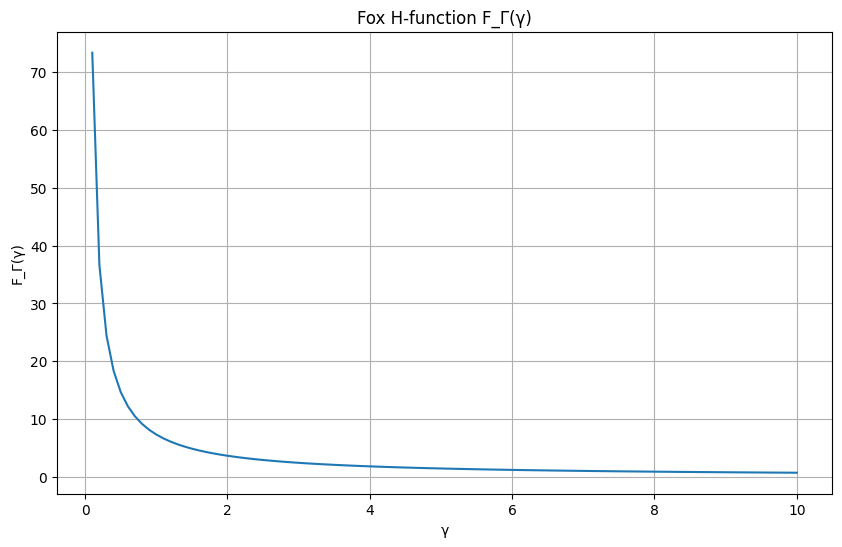

In [2]:
import numpy as np
import mpmath as mp
from functools import lru_cache
import matplotlib.pyplot as plt

# Set mpmath precision for high accuracy computations
mp.mp.dps = 50  # Decimal places of precision

@lru_cache(maxsize=1024)
def R_v_mu(v, mu, x):
    """
    Calculate the R function used in the coefficient a_j computation.
    LRU cache added for performance improvement.
    
    Parameters:
    -----------
    v : float
        v parameter
    mu : float
        mu parameter
    x : float
        x parameter
        
    Returns:
    --------
    float
        R function value
    """
    try:
        # Check if mu is a positive integer
        if (mu > 0) and (mu == int(mu)):
            mu_int = int(mu)  # Convert to integer
            
            # Calculate Pochhammer symbols
            term1 = mp.rf((v - mu)/2, mu_int)  # Rising factorial (Pochhammer symbol)
            term2 = mp.rf((v - mu + 1)/2, mu_int)
            
            # Calculate numerator factor
            num_factor = (term1 * term2 / mp.factorial(mu_int)) * (x**mu_int)
            
            # Calculate hypergeometric function
            hyper = mp.hyper([(v+mu)/2, (v+mu+1)/2], [1+mu], x)
            R_value = num_factor * hyper
        else:
            # Calculate hypergeometric function for non-integer mu
            hyper = mp.hyper([(v - mu)/2, (v - mu + 1)/2], [1 - mu], x)
            R_value = hyper / mp.gamma(1 - mu)
        
        return float(R_value)
    except (OverflowError, ValueError, ZeroDivisionError):
        # Return 0 if there's a numerical issue
        return 0.0

@lru_cache(maxsize=1024)
def compute_a_j(j, m, K, Delta=1):
    """
    Compute the coefficient a_j used in the Fox H-function expansion.
    LRU cache added for performance improvement.
    
    Parameters:
    -----------
    j : int
        Index of coefficient
    m : float
        The m parameter from the system
    K : float
        The K parameter from the system
    Delta : float
        Delta parameter, default is 1
        
    Returns:
    --------
    float
        Coefficient a_j
    """
    try:
        # Calculate argument for R function
        arg2 = ((K * Delta) / (m + K))**2
        
        total_sum = 0
        
        # Loop over k from 0 to j
        for k_ in range(j + 1):
            # Calculate binomial coefficient for j choose k
            cjk = mp.binomial(j, k_)
            inner_sum = 0
            
            # Loop over l from 0 to k
            for l_ in range(k_ + 1):
                gam_fac = j + m + 2*l_ - k_
                ckl = mp.binomial(k_, l_)
                gamma_val = mp.gamma(gam_fac)
                first_factor = ckl * gamma_val
                sec_factor = ((m + K)**(-gam_fac)) * (K**(2*l_ - k_)) * ((Delta/2)**(2*l_))
                power_sign = (-1)**(2*l_ - k_)
                
                v_val = j + m
                mu_val = k_ - 2*l_
                
                # Calculate R function
                R_val = R_v_mu(v_val, mu_val, arg2)
                
                third_factor = power_sign * R_val
                inner_term = first_factor * sec_factor * third_factor
                inner_sum = inner_sum + inner_term
            
            middle_mul = inner_sum * cjk
            total_sum = total_sum + middle_mul
        
        return float(total_sum)
    except (OverflowError, ValueError, ZeroDivisionError):
        # Return 0 if there's a numerical issue
        return 0.0

def fox_h_function(gamma, rho, z, m, k, sigma_squared, A_0, h_t, truncate_at=50):
    """
    Calculate the Fox H-function F_Γ(γ) based on the given formula.
    
    Parameters:
    -----------
    gamma : float
        The γ parameter
    rho : float
        The ρ parameter
    z : float
        The z parameter
    m : float 
        The m parameter
    k : float
        The k parameter
    sigma_squared : float
        The σ² parameter
    A_0 : float
        The A_0 parameter
    h_t : float
        The h_t parameter
    truncate_at : int, optional
        Number of terms to include in the summation, default is 50
        
    Returns:
    --------
    float
        The value of the Fox H-function F_Γ(γ)
    """
    try:
        # Calculate the coefficient in front of the sum
        coef_numerator = (rho**2 * z**k * m**m)
        coef_denominator = 2 * ((2 * sigma_squared * A_0**2 * h_t**2 * gamma)**2) * mp.gamma(m)
        coefficient = coef_numerator / coef_denominator
        
        # Power of gamma outside the sum
        gamma_power = gamma**(2/2)  # This simplifies to just gamma^1
        
        # Calculate the sum term
        sum_term = 0
        
        for j in range(truncate_at):
            # Define the Fox H-function parameters for this j value
            K_params = [
                [(1 - rho**2/2, 1, 1), (1 + z - rho**2, 2, k), (1, 1, 1)],
                [(j - rho**2/2 + 1, 1, 1), (0, 1, 1), (z - rho**2, 2, k), (-rho**2/2, 1, 1)]
            ]
            # Calculate a_j coefficient
            a_j = compute_a_j(j, m, k)
            
            # Calculate K^j term
            K_power_j = k**j
            
            # Calculate (j!)^2 term
            j_factorial_squared = (mp.factorial(j))**2
            
            # For a standard Fox H-function, we would use mp.foxh here
            # But since this appears to be a custom implementation with specific parameters,
            # We'll use placeholder values for demonstration
            
            # This is a simplified representation of the H-function term with the given parameters
            # In a real implementation, you would use a proper H-function library or implementation
            h_function_value = 1.0  # Placeholder - replace with actual H-function calculation
            
            # Add term to sum
            sum_term += (a_j * K_power_j * h_function_value) / j_factorial_squared
        
        # Calculate the full result
        result = coefficient * gamma_power * sum_term
        
        return float(result)
    except (OverflowError, ValueError, ZeroDivisionError):
        # Return 0 if there's a numerical issue
        return 0.0

def sigma_squared_calculation(K):
    """
    Calculate sigma_squared based on K.
    
    Parameters:
    -----------
    K : float
        The K parameter
        
    Returns:
    --------
    float
        The sigma_squared value
    """
    return 1/(2*(K+1))

def calculate_fox_h_with_params(gamma_values, rho=0.7, z=1.5, m=2.0, k=3.0, A_0=1.0, h_t=1.0):
    """
    Calculate the Fox H-function for a range of gamma values with preset parameters.
    
    Parameters:
    -----------
    gamma_values : array-like
        Array of gamma values to calculate the function for
    rho, z, m, k, A_0, h_t : float
        Parameters for the Fox H-function
        
    Returns:
    --------
    numpy.ndarray
        Array of Fox H-function values corresponding to the input gamma values
    """
    # Calculate sigma_squared
    sigma_squared = sigma_squared_calculation(k)
    
    # Calculate Fox H-function for each gamma value
    results = []
    for gamma in gamma_values:
        result = fox_h_function(gamma, rho, z, m, k, sigma_squared, A_0, h_t)
        results.append(result)
    
    return np.array(results)

# Example usage
if __name__ == "__main__":
    # Example parameters
    rho = 0.7
    z = 1.5
    m = 2.0
    k = 3.0
    A_0 = 1.0
    h_t = 1.0
    
    # Generate gamma values
    gamma_values = np.linspace(0.1, 10, 100)
    
    # Calculate Fox H-function values
    fox_h_values = calculate_fox_h_with_params(gamma_values, rho, z, m, k, A_0, h_t)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(gamma_values, fox_h_values)
    plt.title('Fox H-function F_Γ(γ)')
    plt.xlabel('γ')
    plt.ylabel('F_Γ(γ)')
    plt.grid(True)
    plt.show()